A script for loading in tendencies (temperature or salinity) from FAFMIP experiments, with data available on NCI. These tendencies are then binned into watermass coordinates, with a focus on temperature-depth space, but the script should be easily adaptable to other coordinate systems (such as salinity-depth, temperature-latitude, salinity-latitude). I also want to feature a percentile flag too (somehow) (if I get there).

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import netCDF4 as nc
from xhistogram.xarray import histogram

In [2]:
path_fs38 = '/g/data/fs38/publications/CMIP6/FAFMIP/' # For ACCESS-CM2
path_oi10 = '/g/data/oi10/replicas/CMIP6/FAFMIP/'     # For models not ACCESS-CM2

In [88]:
def load_faf_expt_tendencies(model_name, faf_expt_name, variable_type):
    '''
    DESCRIPTION:
    ---
    Load in either temperature or salinity tendency terms from any FAFMIP experiment run currently available on /g/data.
    All the tendency terms are annual averages.
    ---
    OPTIONS:
    ---
    model_name:      'ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'FGOALS-g3', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M'
    faf_expt_name:   'faf-passiveheat', 'faf-heat', 'faf-all', 'faf-water', 'faf-stress'
    variable_type:   'temperature', 'salinity'
    ---
    '''
    
    ### Match model_name to modelling_group ###
    
    if model_name == 'ACCESS-CM2':
        modelling_group = 'CSIRO-ARCCSS'
    elif model_name == 'CAS-ESM2-0':
        modelling_group = 'CAS'
    elif model_name == 'CanESM5':
        modelling_group = 'CCCma'
    elif model_name == 'FGOALS-g3':
        modelling_group = 'CAS'
    elif model_name == 'MIROC6':
        modelling_group = 'MIROC'
    elif model_name == 'MPI-ESM1-2-HR':
        modelling_group = 'MPI-M'
    elif model_name == 'MRI-ESM2-0':
        modelling_group = 'MRI'
    elif model_name == 'CESM2':
        modelling_group = 'NCAR'
    elif model_name == 'GFDL-ESM2M':
        modelling_group = 'NOAA-GFDL'
    
    
    ### Define path to FAFMIP experiments ###
    
    if model_name == 'ACCESS-CM2':
        model_path = path_fs38 + modelling_group + '/' + model_name + '/'
    else:
        model_path = path_oi10 + modelling_group + '/' + model_name + '/'
        
    expt_path = model_path + faf_expt_name + '/*/'

    
    ### Get grid information ###
    
    # Area:
    try:
        if model_name == 'ACCESS-CM2':
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/latest/*.nc')['areacello']
        else:
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/*/*.nc')['areacello']
    except:
        areacello = np.empty(0)
        print('areacello for ' + model_name + ' not found')
    
    # Volume: 
    try:
        if model_name == 'ACCESS-CM2':
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/latest/*.nc')['volcello'].groupby('time.year').mean(dim='time', keep_attrs=True)
        else:
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/*/*.nc')['volcello'].groupby('time.year').mean(dim='time', keep_attrs=True)
            ### NB: Do I want to check if this is available in Ofx if not available at Omon????
            ### Answer: Yes, e.g. not currently available at Omon for CESM2 but is available at Ofx (presumably this is time-mean?)
    except:
        volcello = np.empty(0)
        print('volcello for ' + model_name + ' not found')
        
    
    ### Get available variables for the given model_name for the given variable_type ###
    
    variables = [] # List of budget variables to return at end of function.
    
    tendency_names = ['tend', 'rmadvect', 'padvect', 'psmadvect', 'pmdiff', 'diff']
    
    
    if variable_type == 'temperature':
        
        if model_name == 'ACCESS-CM2':
            temperature_type = 'ocontemp'
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/bigthetao/gn/latest/*.nc')['bigthetao'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Temperature
            #variables.append(xr.open_mfdataset(expt_path + 'Omon/pabigthetao/gn/latest/*.nc')['pabigthetao'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Added_temperature
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/latest/*.nc')[temperature_type + name].groupby('time.year').mean(dim='time', keep_attrs=True)) # Tendency terms
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
            
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/hfds/gn/latest/*.nc')['hfds'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Net surface heat flux
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
                
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/latest/*.nc')['rsdoabsorb'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
                
            
        else:
            temperature_type = 'opottemp'
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/thetao/gn/*/*.nc')['thetao'].groupby('time.year').mean(dim='time', keep_attrs=True))
            #variables.append(xr.open_mfdataset(expt_path + 'Omon/pathetao/gn/*/*.nc')['pathetao'].groupby('time.year').mean(dim='time', keep_attrs=True))
                    
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/*/*.nc')[temperature_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
            
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/hfds/gn/*/*.nc')['hfds'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Net surface heat flux
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
                
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/*/*.nc')['rsdoabsorb'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
    
    if variable_type == 'salinity':
        
        salinity_type = 'osalt'
        salinity = 'so'
        
        if model_name == 'ACCESS-CM2':
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/so/gn/latest/*.nc')['so'].groupby('time.year').mean(dim='time', keep_attrs=True))
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/latest/*.nc')[salinity_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/wfo/gn/latest/*.nc')['wfo'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Net surface water flux
            except:
                variables.append(np.empty(0))
                print('wfo term for ' + model_name + ' not found')
        
        else:
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/so/gn/*/*.nc')['so'].groupby('time.year').mean(dim='time', keep_attrs=True))
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/*/*.nc')[salinity_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/wfo/gn/*/*.nc')['wfo'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Net surface water flux
            except:
                variables.append(np.empty(0))
                print('wfo term for ' + model_name + ' not found')
            
            
    return variables, areacello, volcello

To do:
- add another if statement for if model_name == 'MRI-ESM2-0' then we need 'gr' isntead of 'gn' in monthly variables
- get area file from a single faf experiment, rather than asking if it is present for the particualr experiment, since it is unavailable for some, but since this field is just 2D it doesn't matter if I get it from a different experiment

In [129]:
models = ['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'FGOALS-g3', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M']
test = load_faf_expt_tendencies(models[8], 'faf-passiveheat', 'temperature')

volcello for GFDL-ESM2M not found
rsdoabsorb term for GFDL-ESM2M not found


In [4]:
def surface_forcing_term(hfds, rsdoabsorb):
    '''
    DESCRIPTION:
    ---
    The net surface heat flux term (hfds) and short-wave penetration term (rsdoabsorb) are treated separately for FAFMIP experiments.
    They need to be combined to give a total surface forcing term.
    This function does that, and makes sure xarray keeps nice attributes.
    ---
    OPTIONS:
    ---
    hfds:        The model's hfds term
    rsdoabsorb:  The model's rsdoabsorb term
    ---
    '''
    
    hfds.expand_dims({'lev': 1}).assign_coords({'lev': [5.]})
    
    surf_forc = xr.concat([(rsdoabsorb + hfds).isel(lev=0),\
                           rsdoabsorb.isel(lev=slice(1,None))], dim='lev')
    
    surf_forc_attrs = np.array([[rsdoabsorb.attrs['standard_name'], hfds.attrs['standard_name']],
                               [rsdoabsorb.attrs['long_name'], hfds.attrs['long_name']],
                               [rsdoabsorb.attrs['units'], hfds.attrs['units']]])
    
    surf_forc.attrs.update({'standard_name': f'{surf_forc_attrs[0,0]} plus {surf_forc_attrs[0,1]}',
                    'long_name': f'{surf_forc_attrs[1,0]} plus {surf_forc_attrs[1,1]}',
                      'units': f'{surf_forc_attrs[2,0]}'})
    
    return surf_forc

### Temp-z streamfunction for ACCESS-CM2. 

In [37]:
ACCCESS_CM2_faf_passiveheat_temp = load_faf_expt_tendencies('ACCESS-CM2', 'faf-passiveheat', 'temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

In [38]:
# Using the language of Abhi's 2021 SRC paper:

TEMP = ACCCESS_CM2_faf_passiveheat_temp[0][0] # Temperature field

TEND = ACCCESS_CM2_faf_passiveheat_temp[0][1] # Total tendency
ADV = ACCCESS_CM2_faf_passiveheat_temp[0][2]  # Tendency from residual mean advection 
MESO = ACCCESS_CM2_faf_passiveheat_temp[0][3] # Tendency from eddy advection
SUB = ACCCESS_CM2_faf_passiveheat_temp[0][4]  # Tendency from submesoscale advection
ISO = ACCCESS_CM2_faf_passiveheat_temp[0][5]  # Tendency from mesoscale diffusion
DIA = ACCCESS_CM2_faf_passiveheat_temp[0][6]  # Tendency from dianeautral mixing
SFC = ACCCESS_CM2_faf_passiveheat_temp[0][7]  # Net surface heat flux
SWP = ACCCESS_CM2_faf_passiveheat_temp[0][8]  # Shortwave absorption
surf_forc = surface_forcing_term(SFC, SWP)    # The combined net surface heat flux and shortwave absorption terms
RES = TEND - ADV - ISO - DIA - surf_forc      # The tendency budget residual, as defined by Griffies OMIP budget (see notes below)

area = ACCCESS_CM2_faf_passiveheat_temp[1]    # Area of grid cells
volume = ACCCESS_CM2_faf_passiveheat_temp[2]  # Volume of grid cells

cp = 3992.10322329649 # Constant heat capacity
rho0 = 1035           # Reference density

Resiudal terms! KPP, oither mixing params; other terms not included: surface heat flux terms.

In [25]:
# save_path = '/scratch/e14/mp2135/save_binning_test'

In [39]:
def tendency_term_binning(tendency_term, coordinate, area, bin_size, coordinate_min, coordinate_max):
    '''
    DESCRIPTION:
    Bin tendency terms in temperature-depth or salinity-depth space
    using xhistogram.
    
    Save the new, binned tendency_term as a netcdf file.
    
    This function should be easily adaptable to bin in temperature-latitude 
    or salinity-latitude space (simply use a different binning coordinate, 
    different bins, different dimensions over which to bin, and
    different tendency terms -- as makes sense for the problem)
    ---
    OPTIONS:
    ---
    tendency_term:    A four-dimensional (year, lev, lat, lon) xarray DataArray
    coordinate:       The coordinate into which we bin; either temperature or salinity; a four-dimensional (year, lev, lat, lon) xarray DataArray
    area:             Area of model grid cells
    bin_size:         Float (size of bin to be used to bin tendency_term into coordinate)
    coordinate_min:   Float (maximum of coordinate)
    coordinate_max:   Float (minimum of coordinate)
    ---
    '''
    
    ### Attributes for a nice xarray DataArray at the end ###
    tendency_attrs = [tendency_term.attrs['standard_name'], tendency_term.attrs['long_name']]
    coord_attrs = [coordinate.attrs['standard_name'], coordinate.attrs['long_name']]
    
    ### The edges of the bins of the new coordinate ###
    coordinate_bins = np.arange(coordinate_min, coordinate_max + bin_size, bin_size)
    
    ### Do binning ###
    '''
    The binning coordinate array is the first argument,
    the edges of the bins are coordinate_bins,
    the dimensions are the dimensions over which the histogram is taken,
    the weights are the area-weighted tendency term values
    '''
    
    if 'i' in coordinate.dims:
        # Some models use 'i' and 'j'
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['i', 'j'], weights = tendency_term * area)
        
    elif 'nlon' in coordinate.dims:
        # Some use 'nlon' and 'nlat'
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['nlon', 'nlat'], weights = tendency_term * area)
        
    elif 'x' in coordinate.dims:
        # Others use x and y...
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['x', 'y'], weights = tendency_term * area)
    
    
    ### Update attributes for nice .nc file ###
    tendency_term_binned.attrs.update({'standard_name': f'{tendency_attrs[0]} binned into {coord_attrs[0]}',
                                       'long_name': f'{tendency_attrs[1]} binned into {coord_attrs[1]}'})
    
    
    ### Save as .nc file ###
    
    # Add argument to function that demands save_path
    
    #tendency_term_binned.to_netcdf(save_path)
    
    return tendency_term_binned

In [40]:
def tendency_term_binnned_streamfunction(tendency_term_binned, binned_coordinate):
    '''
    DESCRIPTION:
    Calculate the coordinate-depth streamfunction for the already-binned tendency_term.
    ---
    OPTIONS:
    ---
    tendency_term_binned:  A three-dimensional (year, lev, coordinate_bin) xarray DataArray
    binned_coordinate:     'temperature', 'salinity'
    ---
    '''
    
    if binned_coordinate == 'temperature':
    
        tendency_term_streamfunction = - (tendency_term_binned.cumsum('lev') - tendency_term_binned.sum('lev')) / (cp * rho0 * 1e6)
        
    elif binned_coordinate == 'salinity':
        
        tendency_term_streamfunction = - (tendency_term_binned.cumsum('lev') - tendency_term_binned.sum('lev')) / (1e6)
    
    return tendency_term_streamfunction

In [7]:
delta_T = 0.5
min_T = -2.
max_T = 32.
bins_T = np.arange(min_T, max_T + delta_T, delta_T)

# Tendency terms binned into temperature for ACCESS-CM2 faf-heat

TEND_binned = tendency_term_binning(TEND, TEMP, area, delta_T, min_T, max_T).load()           # Total tendency
ADV_binned = tendency_term_binning(ADV, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from residual mean advection
# MESO_binned = tendency_term_binning(ISO, TEMP, area, delta_T, min_T, max_T).load()            # Tendency from net parameterized eddy advection
# SUB_binned = tendency_term_binning(SUB, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from submesoscale eddy advection
ISO_binned = tendency_term_binning(ISO, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from mesoscale diffusion
DIA_binned = tendency_term_binning(DIA, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from dianeautral mixing
surf_forc_binned = tendency_term_binning(surf_forc, TEMP, area, delta_T, min_T, max_T).load() # Shortwave absorption + net surface heat flux

In [30]:
# Binned tendency terms for ACCESS-CM2 faf-heat streamfunctions

TEND_binned_streamfunc = tendency_term_binnned_streamfunction(TEND_binned, 'temperature')
ADV_binned_streamfunc = tendency_term_binnned_streamfunction(ADV_binned, 'temperature')
# MESO_binned_streamfunc = tendency_term_binnned_streamfunction(MESO_binned, 'temperature')
# SUB_binned_streamfunc = tendency_term_binnned_streamfunction(SUB_binned, 'temperature')
ISO_binned_streamfunc = tendency_term_binnned_streamfunction(ISO_binned, 'temperature')
DIA_binned_streamfunc = tendency_term_binnned_streamfunction(DIA_binned, 'temperature')
surf_forc_binned_streamfunc = tendency_term_binnned_streamfunction(surf_forc_binned, 'temperature')

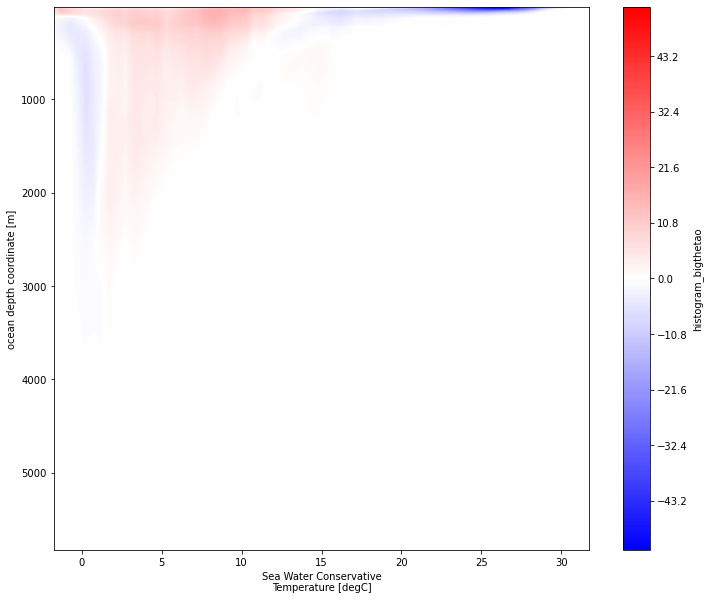

In [34]:
plt.figure(figsize=(12,10))
(ADV_binned_streamfunc).isel(year=slice(-20,None)).mean('year').sel(bigthetao_bin=slice(None,None)).sel(lev=slice(None,None)).plot.contourf(yincrease=False,
                                                                                                                                 levels=300,
                                                                                                                                 cmap='bwr')

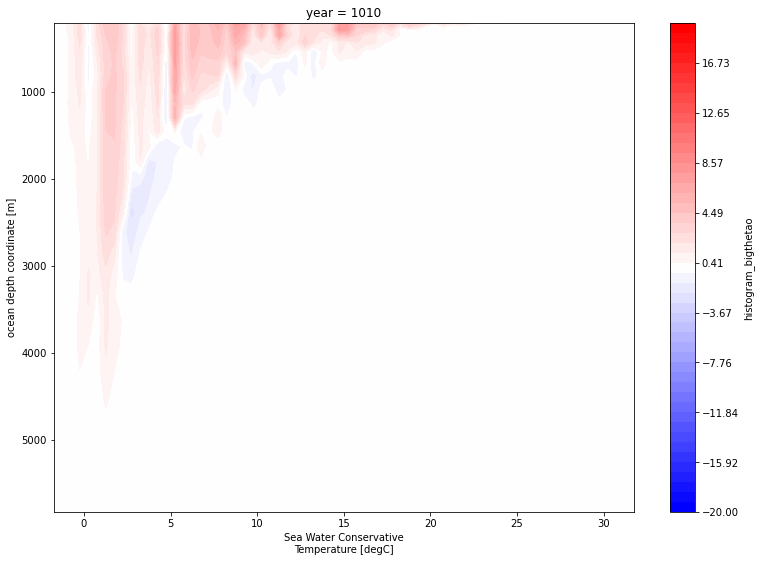

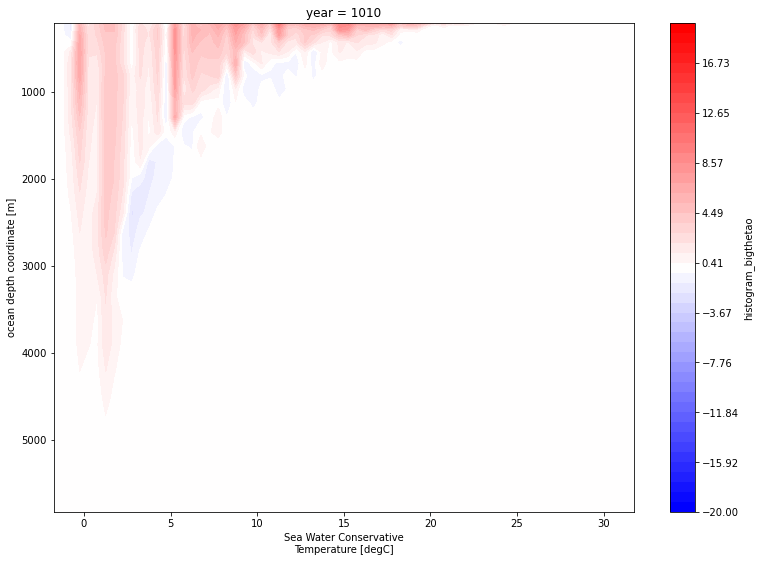

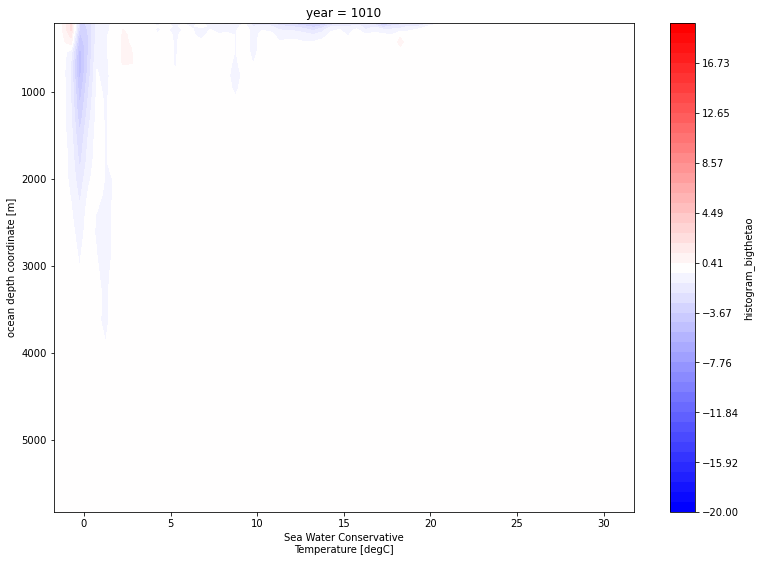

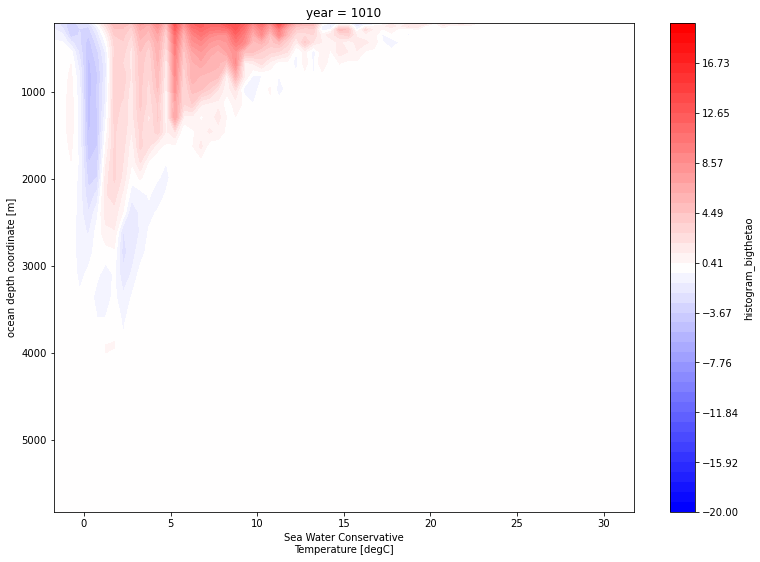

In [51]:
LHS = TEND_binned_streamfunc

RHS = ADV_binned_streamfunc + ISO_binned_streamfunc + DIA_binned_streamfunc + surf_forc_binned_streamfunc# + SUB_binned
# is SUB_binned not incorporated into ADV_binned...? Griffies 2016 OMIP says it should be...

# vmin = -1.7e13
# vmax = -vmin

vmin=-20
vmax=-vmin

year = 60

plt.figure(figsize=(13,9))
(LHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(RHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(LHS - RHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(ADV_binned_streamfunc).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

Doesn't look like it closes very well at all... What am I missing?

As Ryan said in the cmip-wm-diagnostics channel, is this residual due to missing 'mixdownslope' and 'temp_sigma_diff' terms?
Is it due to the fact that we only have yearly snapshots/averages? Tendency from numerical mixing?
Hmph...

Let's see with a different model:

In [39]:
CESM2_fafheat_temp = load_faf_expt_tendencies('CESM2', 'faf-heat', 'temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


volcello for CESM2 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemptend' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemprmadvect' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemppadvect' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemppsmadvect' has multiple fill values {1e+20, 1e+20}, deco

In [41]:
TEMP_CESM2 = CESM2_fafheat_temp[0][0] # Temperature field
TEND_CESM2 = CESM2_fafheat_temp[0][1] # Total tendency
ADV_CESM2 = CESM2_fafheat_temp[0][2]  # Tendency from residual mean advection 
# MESO_CESM2 = CESM2_fafheat_temp[0][3] # Tendency from eddy advection
# SUB_CESM2 = CESM2_fafheat_temp[0][4]  # Tendency from submesoscale advection
ISO_CESM2 = CESM2_fafheat_temp[0][5]  # Tendency from mesoscale diffusion
DIA_CESM2 = CESM2_fafheat_temp[0][6]  # Tendency from dianeautral mixing
SFC_CESM2 = CESM2_fafheat_temp[0][7]  # Net surface heat flux
SFC_CESM2 = SFC_CESM2.expand_dims({'lev': 1}).assign_coords({'lev': [5.]})
SWP_CESM2 = CESM2_fafheat_temp[0][8]  # Shortwave absorption

surf_forc_CESM2 = xr.concat([(SFC_CESM2 + SWP_CESM2.isel(lev=0)),\
           SWP_CESM2.isel(lev=slice(1,None))], dim='lev')
surf_forc_CESM2_attrs = np.array([[SWP_CESM2.attrs['standard_name'], SFC_CESM2.attrs['standard_name']],
                               [SWP_CESM2.attrs['long_name'], SFC_CESM2.attrs['long_name']],
                               [SWP_CESM2.attrs['units'], SFC_CESM2.attrs['units']]])
surf_forc_CESM2.attrs.update({'standard_name': f'{surf_forc_CESM2_attrs[0,0]} plus {surf_forc_CESM2_attrs[0,1]}',
                    'long_name': f'{surf_forc_CESM2_attrs[1,0]} plus {surf_forc_CESM2_attrs[1,1]}',
                      'units': f'{surf_forc_CESM2_attrs[2,0]}'})

area_CESM2 = CESM2_fafheat_temp[1]    # Area of grid cells
volume_CESM2 = CESM2_fafheat_temp[2]  # Volume of grid cells

In [42]:
# Tendency terms binned into temperature for CESM faf-heat

TEND_CESM2_binned = tendency_term_binning(TEND, TEMP, area, delta_T, min_T, max_T).load()    # Total tendency
ADV_CESM2_binned = tendency_term_binning(ADV, TEMP, area, delta_T, min_T, max_T) .load()     # Tendency from residual mean advection
MESO_CESM2_binned = tendency_term_binning(MESO, TEMP, area, delta_T, min_T, max_T).load()    # Tendency from eddy advection
SUB_CESM2_binned = tendency_term_binning(SUB, TEMP, area, delta_T, min_T, max_T).load()      # Tendency from submesoscale advection
ISO_CESM2_binned = tendency_term_binning(ISO, TEMP, area, delta_T, min_T, max_T).load()      # Tendency from mesoscale diffusion
DIA_CESM2_binned = tendency_term_binning(DIA, TEMP, area, delta_T, min_T, max_T).load()      # Tendency from dianeautral mixing
# SWP_CESM2_binned = tendency_term_binning(SWP, TEMP, area, delta_T, min_T, max_T)  # Shortwave absorption
surf_forc_CESM2_binned = tendency_term_binning(surf_forc, TEMP, area, delta_T, min_T, max_T).load()   # Shortwave absorption + net surface heat flux

In [43]:
# Binned tendency terms for ACCESS-CM2 faf-passiveheat streamfunctions

TEND_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(TEND_binned, 'temperature')
ADV_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(ADV_binned, 'temperature')
# MESO_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(MESO_binned, 'temperature')
SUB_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(SUB_binned, 'temperature')
ISO_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(ISO_binned, 'temperature')
DIA_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(DIA_binned, 'temperature')
surf_forc_CESM2_binned_streamfunc = tendency_term_binnned_streamfunction(surf_forc, 'temperature')

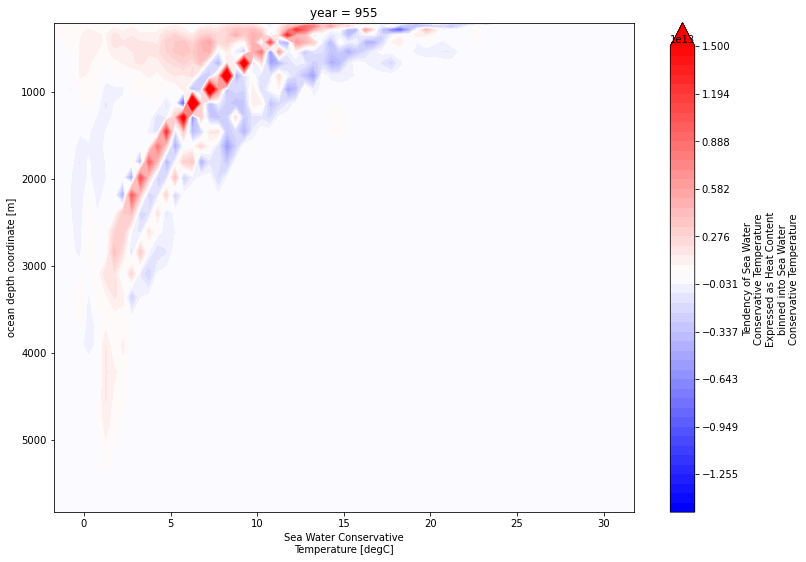

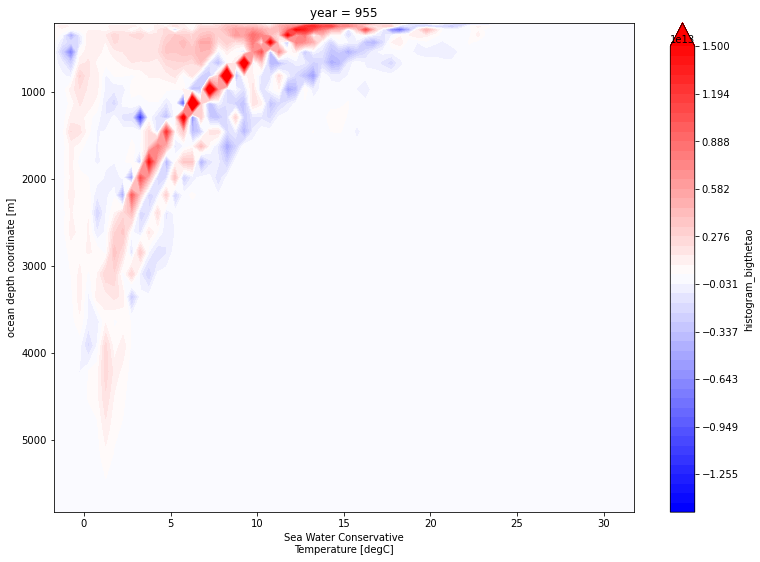

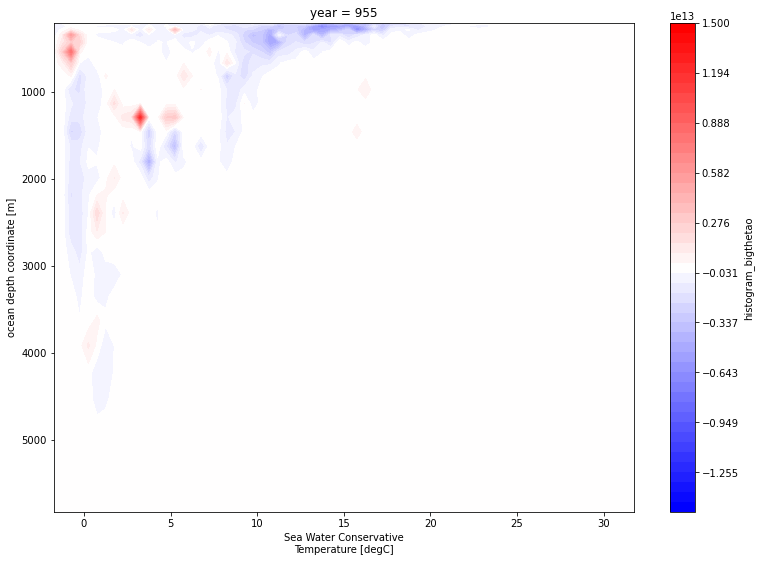

In [44]:
LHS = TEND_CESM2_binned

RHS = ADV_CESM2_binned + ISO_CESM2_binned + DIA_CESM2_binned + surf_forc_CESM2_binned # SUB_binned

vmin = -1.5e13
vmax = -vmin

year = 5
depth_start = 200

plt.figure(figsize=(13,9))
(LHS).isel(year=year).sel(lev=slice(depth_start,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))
# (LHS).mean('year').sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr')

plt.figure(figsize=(13,9))
(RHS).isel(year=year).sel(lev=slice(depth_start,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))
# (RHS).mean('year').sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr')

plt.figure(figsize=(13,9))
(LHS - RHS).isel(year=year).sel(lev=slice(depth_start,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))
# (LHS - RHS).mean('year').sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr')

### Temperature-depth streamfunctions for all models in FAFPASSIVE runs

In [50]:
def fafpassive_TZstreamfuncs(models):
    
    streamfuncs = []
    
    for model in models:
        
        model_vars = load_faf_expt_tendencies(model, 'faf-passiveheat', 'temperature')
        
        temp = model_vars[0][0]
        adv = model_vars[0][2]
        area = model_vars[1]
        
        if area.size == 0:
            print (f'area field not available for {model}, therefore cannot bin in coordinate')
            continue
        
        streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(adv, temp, area, delta_T, min_T, max_T), 'temperature').load()
        
        streamfuncs.append(streamfunc)
        
        print(f'{model} done')
        
    return streamfuncs

In [51]:
fafpassive_streamfuncs = fafpassive_TZstreamfuncs(['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'MPI-ESM1-2-HR', 'CESM2', 'GFDL-ESM2M'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

ACCESS-CM2 done
areacello for CAS-ESM2-0 not found
volcello for CAS-ESM2-0 not found
opottemppsmadvect term for CAS-ESM2-0 not found
rsdoabsorb term for CAS-ESM2-0 not found
area field not available for CAS-ESM2-0, therefore cannot bin in coordinate
volcello for CanESM5 not found
opottemppsmadvect term for CanESM5 not found
CanESM5 done
volcello for MPI-ESM1-2-HR not found
opottemppsmadvect term for MPI-ESM1-2-HR not found
MPI-ESM1-2-HR done
volcello for CESM2 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemptend' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemprmadvect' has multiple fill values {1e+20, 1e+20}, decoding all values t

CESM2 done
volcello for GFDL-ESM2M not found
rsdoabsorb term for GFDL-ESM2M not found
GFDL-ESM2M done


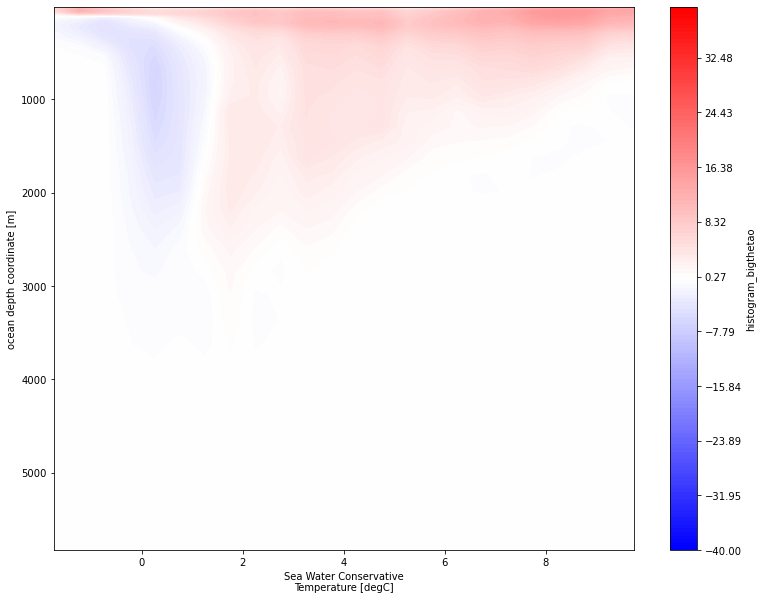

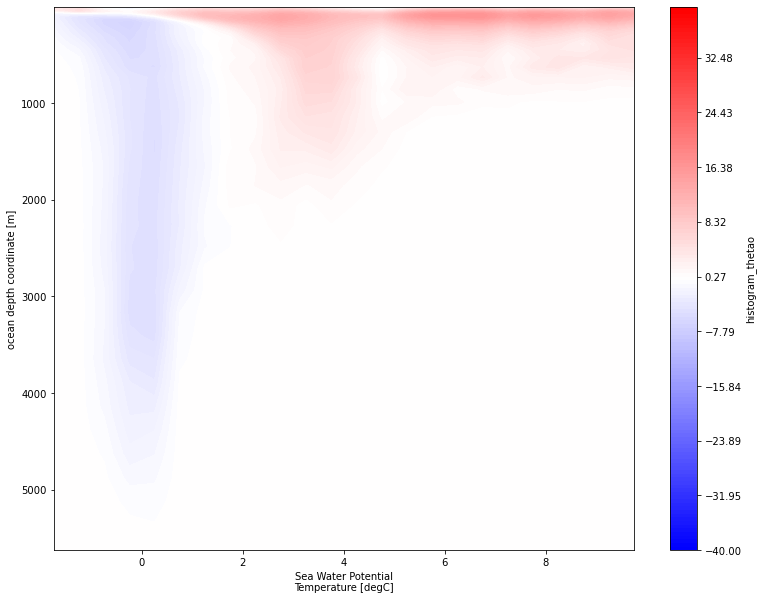

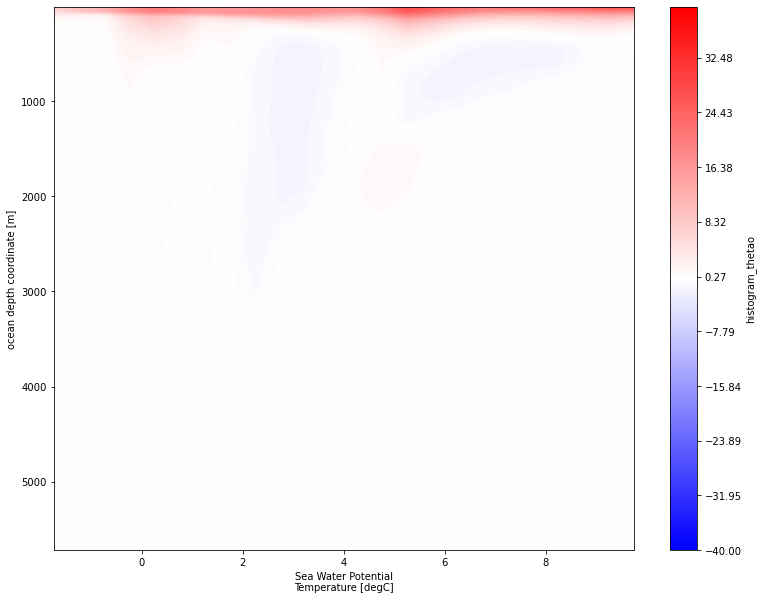

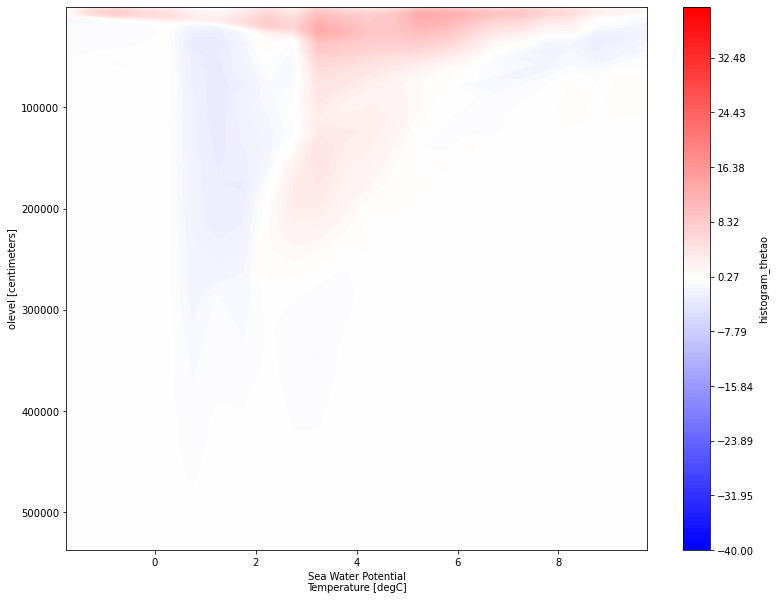

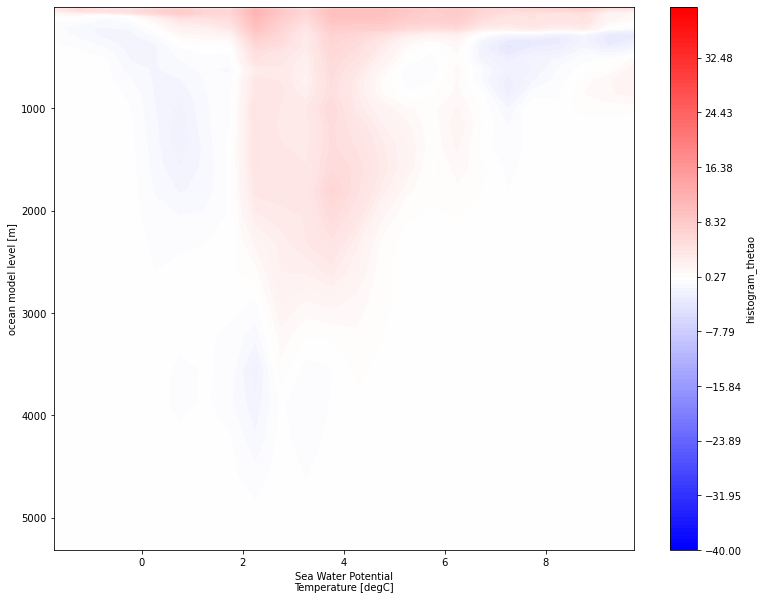

In [87]:
model_index = 0
year_index = 2

vmin = -40
vmax = -vmin

for i in range(5):
    
    plt.figure(figsize=(13,10))
    (fafpassive_streamfuncs[i]).isel(year=slice(-20,None)).mean('year').sel(lev=slice(None,None))[:,:24].plot.contourf(yincrease=False,levels=150,cmap='bwr',
                                                                                                   vmin=vmin,
                                                                                                   vmax=vmax)